# Transfer Learning Tutorial

CS231n 강의 노트에 따르면

>충분한 양의 데이터를 모으기가 쉽지 않기 때문에
>실제적으로 CNN 전체를 훈련시키는 경우는 거의 없다.
>대신 사전에 훈련시킨 CNN을 시작점으로 사용한다.

전이 학습의 두가지 방법은 다음과 같다.

* <b> Convnet을 미세조정 </b> : 랜덤 초기화 대신 사전 훈련한 신경망으로 초기화한다. 나머지는 평소와 같다.

* <b> Convnet을 특성 추출기로 사용 </b> : 마지막 완전연결층을 제외한 네트워크를 얼려서 사용한다.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, os, copy

plt.ion()

## 데이터 불러오기

데이터 로딩을 위해 torchvision 및 torch.utils.data 패키지를 사용한다.

이번에 해결하려는 문제는 개미와 벌을 분류하는 모델을 훈련시키는 것이다. 개미와 벌의 훈련 이미지는 각각 120개, 검증 이미지는 75개가 준비되어 있다. 이는 처음부터 훈련시킨다면 굉장히 작은 데이터셋이지만, 전이 학습을 사용하면 충분히 일반화시킬 수 있을 것이다.

이 데이터셋은 이미지넷의 작은 부분이다. [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)에서 데이터셋을 다운 받고 현재 폴더에 저장하라.

In [115]:
# 훈련을 위한 데이터 증식 및 정규화 
# 검증셋에는 정규화만 적용

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225]) 
        # PyTorch의 이미지 모델들은 이렇게 normalize 해야함
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x]) #ImageFolder의 결과로 자동으로 class를 붙임
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=0)
             for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [118]:
len(image_datasets['train']), len(dataloaders['train'])

(244, 61)

In [11]:
class_names, dataset_sizes

(['ants', 'bees'], {'train': 244, 'val': 153})

## 이미지 시각화

데이터 증식의 결과를 시각화를 통해 파악해보자.

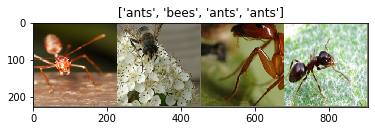

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std* inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # plot이 업데이트될 때까지 잠시 대기
    
# 훈련 데이터의 배치 
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 만듦
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 훈련

모델을 훈련시키기 위해 다음을 수행하는 함수를 만들자. 
* 러닝 레이트를 결정하고
* 가장 좋은 모델을 저장

여기서 `scheduler`는 `torch.optim.lr_scheduler`에서 가져옴

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict()) # 깊은 복사로 별도로 저장
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        
        # 각 에폭마다 훈련/검증 
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # 모델을 훈련 모드로 전환
            else:
                model.eval() # 모델을 평가 모드로 전환
                
            
            running_loss = 0.0
            running_corrects = 0
            
            # 데이터 순환
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 파라미터 그레디언트 초기화
                optimizer.zero_grad()
                
                # 순전파
                # 훈련 모드일 때는 히스토리를 기록
                with torch.set_grad_enabled(phase=='train'):
                    # phase == 'train' 이면 gradient 업데이트,
                    # 아니면 with torch.no_grad() 와 동일하게 동작
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # 예측값
                    loss = criterion(outputs, labels)
                    
                    # 역전파는 훈련 모드일 때만
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # 통계치 산출
                running_loss += loss.item() * inputs.size(0) 
                # loss = sum(loss(minibatch))/len(minibatch) > 따라서 4곱해야 훈련셋 하나마다의 loss가 나옴
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase] # 훈련데이터 하나마다의 loss
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # 모델의 성능이 좋을 경우 깊은 복사로 저장함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # 가장 좋은 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model # epoch 중 가장 좋은 상태의 모델을 반환
    

## 모델의 예측 시각화

In [122]:
model_ft.eval()
print(model_ft.training)
model_ft.train()
print(model_ft.training)

False
True


In [124]:
for i, (inputs, labels) in enumerate(dataloaders['val']):
    print(inputs.size())
    if i==0:break

torch.Size([4, 3, 224, 224])


In [127]:
def visualize_model(model, num_images=6):
    was_training = model.training # 모델의 훈련/평가 상태
    model.eval() # 이젠 model.training==False
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad(): # 더이상 그레디언트 업데이트 안함
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

## Convnet 을 미세 조정

사전에 훈련된 모델을 로드한 후 마지막 완전연결층을 리셋함

In [120]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 최적화 과정에서 모든 파라미터를 대상으로 함
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 매 7 에폭마다 러닝 레이트를 0.1씩 감소시킴
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [131]:
model_ft.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221

In [132]:
optimizer_ft.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'initial_lr': 0.001,
   'params': [2291849968592,
    2291849968232,
    2291849969312,
    2291849965856,
    2291849969528,
    2291849967080,
    2291849968736,
    2291849965928,
    2291849987128,
    2291849988928,
    2291849988208,
    2291849988136,
    2291849989216,
    2291849923536,
    2291849923320,
    2291849922384,
    2291849922168,
    2291849922312,
    2291849942864,
    2291849942000,
    2291849943656,
    2291849922744,
    2291849922096,
    2291849924544,
    2291849944376,
    2291849943584,
    2291849900752,
    2291849903560,
    2291849902696,
    2291849902624,
    2291849967512,
    2291849687184,
    2291849687472,
    2291849690856,
    2291849689560,
    2291849687616,
    2291849900320,
    2291849901400,
    2291849901328,
    2291849687256,
    2291827232632,
    2291755341000,
    2291849905568,
    2291849904848,
 

## 훈련과 평가

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=28)

Epoch 0/27
----------
train Loss: 0.5500 Acc: 0.7295
val Loss: 0.2611 Acc: 0.9085

Epoch 1/27
----------
train Loss: 0.4057 Acc: 0.8484
val Loss: 0.2832 Acc: 0.8758

Epoch 2/27
----------
train Loss: 0.5509 Acc: 0.7541
val Loss: 0.5131 Acc: 0.8366

Epoch 3/27
----------
train Loss: 0.4947 Acc: 0.8115
val Loss: 0.3508 Acc: 0.8889

Epoch 4/27
----------
train Loss: 0.5056 Acc: 0.7910
val Loss: 0.3517 Acc: 0.8758

Epoch 5/27
----------
train Loss: 0.4148 Acc: 0.8197
val Loss: 0.4007 Acc: 0.8497

Epoch 6/27
----------
train Loss: 0.4837 Acc: 0.8279
val Loss: 0.1639 Acc: 0.9542

Epoch 7/27
----------
train Loss: 0.2982 Acc: 0.8689
val Loss: 0.1528 Acc: 0.9608

Epoch 8/27
----------
train Loss: 0.3961 Acc: 0.8361
val Loss: 0.1587 Acc: 0.9542

Epoch 9/27
----------
train Loss: 0.2979 Acc: 0.8566
val Loss: 0.1536 Acc: 0.9608

Epoch 10/27
----------
train Loss: 0.2473 Acc: 0.8934
val Loss: 0.1544 Acc: 0.9673

Epoch 11/27
----------
train Loss: 0.2536 Acc: 0.8975
val Loss: 0.1486 Acc: 0.9673

Ep

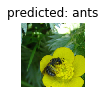

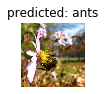

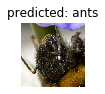

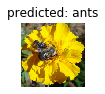

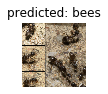

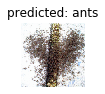

In [128]:
visualize_model(model_ft)

## 고정된 특성 추출기로서의 Convnet

여기서는 마지막 층을 제외한 모든 신경망을 얼려야 한다. 따라서 `requires_grad == False`를 사용하여 역전파 과정에서 파라미터의 그레디언트가 계산되지 않도록 해야 한다.

이 [문서](https://pytorch.org/docs/master/notes/autograd.html)에서 더 많은 정보를 확인할 수 있다.

In [45]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad= False
    
# 새로 만든 모듈의 파라미터는 requires_grad=True를 설정해야 함
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# 마지막 층의 파라미터만 최적화됨
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 매 7 에폭마다 러닝 레이트를 0.1씩 감소시킴
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 훈련과 평가

In [46]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=28)

Epoch 0/27
----------
train Loss: 0.6365 Acc: 0.6639
val Loss: 0.2474 Acc: 0.9085

Epoch 1/27
----------
train Loss: 0.4685 Acc: 0.7746
val Loss: 0.2503 Acc: 0.8954

Epoch 2/27
----------
train Loss: 0.4710 Acc: 0.7951
val Loss: 0.3984 Acc: 0.8562

Epoch 3/27
----------
train Loss: 0.4149 Acc: 0.8115
val Loss: 0.2494 Acc: 0.9085

Epoch 4/27
----------
train Loss: 0.5581 Acc: 0.7869
val Loss: 0.2195 Acc: 0.9150

Epoch 5/27
----------
train Loss: 0.6585 Acc: 0.7705
val Loss: 0.2366 Acc: 0.9346

Epoch 6/27
----------
train Loss: 0.6162 Acc: 0.7541
val Loss: 0.2371 Acc: 0.9281

Epoch 7/27
----------
train Loss: 0.6607 Acc: 0.7500
val Loss: 0.4629 Acc: 0.8627

Epoch 8/27
----------
train Loss: 0.4010 Acc: 0.8770
val Loss: 0.2490 Acc: 0.9150

Epoch 9/27
----------
train Loss: 0.3338 Acc: 0.8443
val Loss: 0.2215 Acc: 0.9346

Epoch 10/27
----------
train Loss: 0.4709 Acc: 0.8197
val Loss: 0.2009 Acc: 0.9477

Epoch 11/27
----------
train Loss: 0.5922 Acc: 0.7623
val Loss: 0.3251 Acc: 0.8954

Ep

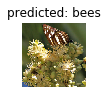

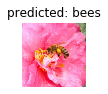

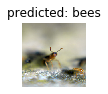

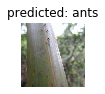

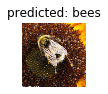

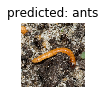

In [39]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [40]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [43]:
model_test = torchvision.models.resnet18(pretrained=True)
print(model_test)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## 추가 : requires_grad = False 와 optimizer 대상 한정 사이의 관계 파악

requires_grad 설정 검사

In [95]:
model_test = torchvision.models.resnet18(pretrained=True)
# for param in model_test.parameters():
#     print(param.requires_grad)
for name, param in model_test.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.weight True
layer2.1.bn1.weight True
layer2.1.bn1.bias True
layer2.1.conv2.weight True
layer2.1.bn2.weight True
layer2.1.bn2.bias True
layer3.0.conv1.weight True
layer3.0.bn1.weight True
layer3.0.bn1.bias True
layer3.0.conv2.weight True
layer3.0.bn2.weight True
layer3.0.bn2.bias True
layer3.0.downsample.0.weight True
layer3.0.downsample.1.weight True
layer3.0.downsample.1.bias True
la

In [63]:
print(model_test)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

pretrained model 의 parameter를 저장

In [59]:
org_param = []
for param in model_test.parameters():
    org_param.append(copy.deepcopy(param))

In [70]:
org_param[len(org_param)-1]

Parameter containing:
tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
         1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
        -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
        -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
         7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
         1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
         6.5269e-03, -1.2041e-02,  9.0427e-03, -8.3279e-04,  8.8647e-03,
        -2.6307e-02, -1.4588e-02,  2.9433e-03,  2.9718e-03, -1.9125e-02,
        -4.7922e-03,  1.3828e-02,  9.8802e-03, -1.8417e-02,  1.9734e-02,
         1.6941e-03,  1.2420e-02, -5.5842e-03, -1.0612e-02,  3.9847e-04,
         4.2733e-03, -1.3298e-02,  2.0661e-02,  1.6963e-02,  2.7952e-03,
         7.4214e-04,  1.3168e-02,  3.2213e-03,  1.0458e-02,  1.6511e-02,
         9.1717e-04,  3.9388e-03, -5.6534e-03,  1.9372e-02,  7.5238e-03,
         1.3437e-02, -1.3185e

In [65]:
num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, 2)

마지막 층을 바꾼 후 파라미터 저장

In [66]:
lin_param = []
for param in model_test.parameters():
    lin_param.append(copy.deepcopy(param))

In [69]:
lin_param[len(lin_param)-1]

Parameter containing:
tensor([-0.0330,  0.0300], requires_grad=True)

In [72]:
model_test = model_test.to(device)
criterion = nn.CrossEntropyLoss()

# 마지막 층의 파라미터만 최적화
optimizer_test = optim.SGD(model_test.fc.parameters(), lr=0.001, momentum=0.9)


# 매 7 에폭마다 러닝 레이트를 0.1씩 감소시킴
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


model_test = train_model(model_test, criterion, optimizer_test,
                         exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.6605 Acc: 0.6393
val Loss: 0.2810 Acc: 0.8889

Epoch 1/2
----------
train Loss: 0.4366 Acc: 0.7910
val Loss: 0.1700 Acc: 0.9412

Epoch 2/2
----------
train Loss: 0.5841 Acc: 0.7541
val Loss: 0.5556 Acc: 0.7778

Training complete in 0m 17s
Best val Acc: 0.9412


모든 레이어의 `requires_grad==True`인 상태에서 마지막 레이어만 훈련시킨 경우의 파라미터는?

In [74]:
fc_train_param = []
for param in model_test.parameters():
    fc_train_param.append(copy.deepcopy(param))

In [83]:
fc_train_param[len(fc_train_param)-1] # 이전과 달라짐

Parameter containing:
tensor([-0.0254,  0.0224], device='cuda:0', requires_grad=True)

In [76]:
org_param[0]

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [84]:
lin_param[0] # 초기와 동일

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [85]:
fc_train_param[0] # 초기와 동일

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

따라서 optimize 대상을 한정하는 것만으로도 이전 층들의 파라미터 업데이트는 방지할 수 있다.

다음으로 모든 파라미터 업데이트를 설정해보자.

In [79]:
optimizer_test_all = optim.SGD(model_test.parameters(), lr=0.001, momentum=0.9)


model_test_all = train_model(model_test, criterion, optimizer_test_all,
                         exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.4164 Acc: 0.7828
val Loss: 0.1916 Acc: 0.9346

Epoch 1/2
----------
train Loss: 0.5925 Acc: 0.7787
val Loss: 0.2682 Acc: 0.9085

Epoch 2/2
----------
train Loss: 0.5306 Acc: 0.7951
val Loss: 0.3111 Acc: 0.8889

Training complete in 0m 20s
Best val Acc: 0.9346


모든 파라미터 업데이트 후 결과는?

In [80]:
all_train_param = []
for param in model_test.parameters():
    all_train_param.append(copy.deepcopy(param))

In [87]:
all_train_param[len(all_train_param)-1] # fc만 훈련시킨 경우와 달라짐

Parameter containing:
tensor([-0.0273,  0.0244], device='cuda:0', requires_grad=True)

In [88]:
all_train_param[0] # fc만 훈련시킨 경우와 달라짐

Parameter containing:
tensor([[[[-4.4379e-03, -1.3075e-03,  3.9913e-03,  ...,  6.0775e-02,
            2.0578e-02, -9.1594e-03],
          [ 1.4359e-02,  1.2027e-02, -1.0739e-01,  ..., -2.6930e-01,
           -1.2745e-01,  5.2298e-03],
          [-4.6767e-03,  6.0717e-02,  2.9683e-01,  ...,  5.2219e-01,
            2.5904e-01,  6.5962e-02],
          ...,
          [-2.6137e-02,  1.5937e-02,  7.3357e-02,  ..., -3.3059e-01,
           -4.1858e-01, -2.5544e-01],
          [ 3.0337e-02,  4.0154e-02,  6.2466e-02,  ...,  4.1536e-01,
            3.9564e-01,  1.6852e-01],
          [-1.4278e-02, -4.5903e-03, -2.4821e-02,  ..., -1.4860e-01,
           -8.0739e-02, -4.2533e-03]],

         [[-8.4528e-03, -2.4563e-02, -3.1350e-02,  ...,  3.5081e-02,
            2.8117e-03, -2.2502e-02],
          [ 4.6267e-02,  3.3429e-02, -1.0429e-01,  ..., -3.1228e-01,
           -1.6027e-01, -2.3830e-04],
          [-1.1184e-03,  9.7636e-02,  4.0147e-01,  ...,  7.0894e-01,
            3.7033e-01,  1.2686e-01]

### 따라서 optimizer 대상을 한정하는 것만으로도 충분함!

다음으로 `requires_grad == False` 로 하고 optimizer를 전체로 해보자.

In [105]:
model_test = torchvision.models.resnet18(pretrained=True)
for param in model_test.parameters():
    param.requires_grad=False

model_test.fc = nn.Linear(num_ftrs, 2)
model_test = model_test.to(device)

In [106]:
print(model_test)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [107]:
for name, param in model_test.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

In [108]:
org_param2 = []
for param in model_test.parameters():
    org_param2.append(copy.deepcopy(param))

In [109]:
org_param2[0]

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [110]:
org_param2[len(org_param2)-1]

Parameter containing:
tensor([ 0.0127, -0.0186], device='cuda:0', requires_grad=True)

In [111]:
optimizer_test_all = optim.SGD(model_test.parameters(), lr=0.001, momentum=0.9)

model_test_all = train_model(model_test, criterion, optimizer_test_all,
                         exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.5989 Acc: 0.7008
val Loss: 0.5077 Acc: 0.7778

Epoch 1/2
----------
train Loss: 0.4711 Acc: 0.7787
val Loss: 0.3519 Acc: 0.8235

Epoch 2/2
----------
train Loss: 0.3656 Acc: 0.8320
val Loss: 0.2465 Acc: 0.9085

Training complete in 0m 13s
Best val Acc: 0.9085


In [112]:
all_train_param2 = []
for param in model_test.parameters():
    all_train_param2.append(copy.deepcopy(param))

In [113]:
all_train_param2[0]

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [114]:
all_train_param2[len(all_train_param2)-1]

Parameter containing:
tensor([ 0.0192, -0.0251], device='cuda:0', requires_grad=True)

> 결론 : requires_grad = False 나 optimizer의 대상을 한정하거나 둘 중 하나면 충분!